In [1]:
import requests
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
%matplotlib inline
model_path = './'
target_col='price'

In [2]:
data = pd.read_csv("D:/학교/4학년/1학기/캡스톤디자인/[final]과일 데이터/사과/후지/data.csv")

In [3]:
del data['date']

In [4]:
data.head()

,평균기온(°C),최저기온(°C),최고기온(°C),유통비용,생산량,price
0,-3.3,-5.2,-1.2,45.0,460285000.0,18089
1,-6.7,-9.6,-3.3,45.0,460285000.0,18080
2,-9.0,-14.3,-3.9,45.0,460285000.0,18080
3,-9.7,-17.7,-2.1,45.0,460285000.0,18180
4,-8.7,-16.9,0.4,45.0,460285000.0,18180


In [5]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [6]:
train, test = train_test_split(data, test_size=0.2)

In [7]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

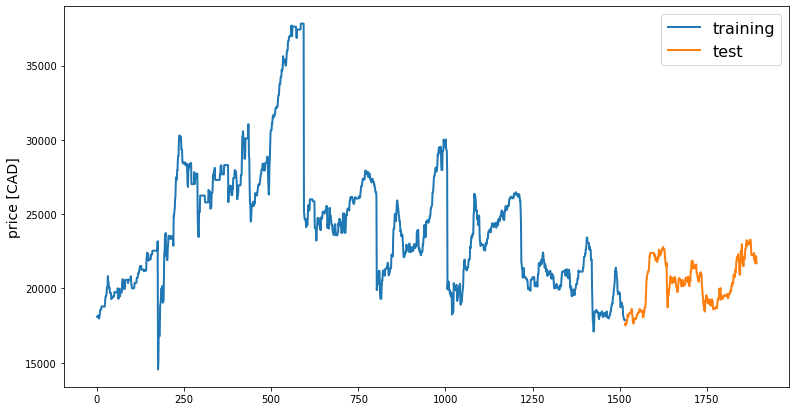

In [8]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

##### 스케일 조정하기

train에 MinMaxScaler(feature_range=-1,1) 을 이용하여 스케일을 조정합니다. 스케일조정에서 어떤 코드에선 0~1사이로 또 어떤 코드에선 standardization을 적용하는 것을 보았습니다. 그래서 정확히 어떤 스케일러를 써야하는지는 저도 잘 모르겠네요. ;

In [9]:
#정규화
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['평균기온(°C)','최저기온(°C)','최고기온(°C)','유통비용','생산량','price']
learn_data_scaled = scaler.fit_transform(data[scale_cols])

learn_data_scaled = pd.DataFrame(learn_data_scaled, index = data.index)
learn_data_scaled.columns = scale_cols

#### 데이터 나누기

이제 모델링을 하기위해 한단계씩 진행해보겠습니다. 먼저 전체 데이터를 train,valid,test 세가지 세트로 나눕니다. 비율은 적당히 (..) 하시면 됩니다.

In [10]:
train, test = train_test_split(learn_data_scaled, test_size=0.2)

In [11]:
def make_dataset(data, label, window_size=30):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [12]:
feature_cols = ['평균기온(°C)','최저기온(°C)','최고기온(°C)',
                '유통비용','생산량']
label_cols = ['price']

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 30)

test_feature = test[feature_cols]
test_label = test[label_cols]

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 30)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature,
                                                      train_label,
                                                      test_size=0.2)

In [13]:
model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]),
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(784,activation='relu'))
model.add(Dense(784,activation='relu'))
model.add(Dense(600,activation='relu'))
model.add(Dense(300,activation='relu'))
model.add(Dense(160,activation='relu'))
model.add(Dense(80,activation='relu'))
model.add(Dense(1))

In [14]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=4,
                    shuffle=False,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
290/297 [============================>.] - ETA: 0s - loss: 0.0200
Epoch 00001: val_loss improved from inf to 0.01649, saving model to .\tmp_checkpoint.h5
297/297 [==============================] - 2s 6ms/step - loss: 0.0199 - val_loss: 0.0165
Epoch 2/100
288/297 [============================>.] - ETA: 0s - loss: 0.0112
Epoch 00002: val_loss improved from 0.01649 to 0.00969, saving model to .\tmp_checkpoint.h5
297/297 [==============================] - 2s 6ms/step - loss: 0.0110 - val_loss: 0.0097
Epoch 3/100
292/297 [============================>.] - ETA: 0s - loss: 0.0080
Epoch 00003: val_loss improved from 0.00969 to 0.00716, saving model to .\tmp_checkpoint.h5
297/297 [==============================] - 2s 6ms/step - loss: 0.0079 - val_loss: 0.0072
Epoch 4/100
291/297 [============================>.] - ETA: 0s - loss: 0.0057
Epoch 00004: val_loss improved from 0.00716 to 0.00447, saving model to .\tmp_checkpoint.h5
297/297 [==============================] - 2s 6ms/step - 

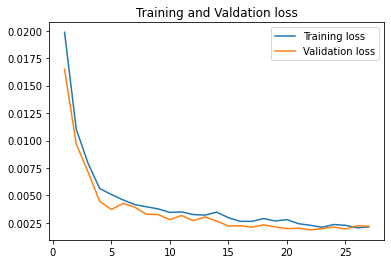

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Valdation loss')
plt.legend()
plt.show()  

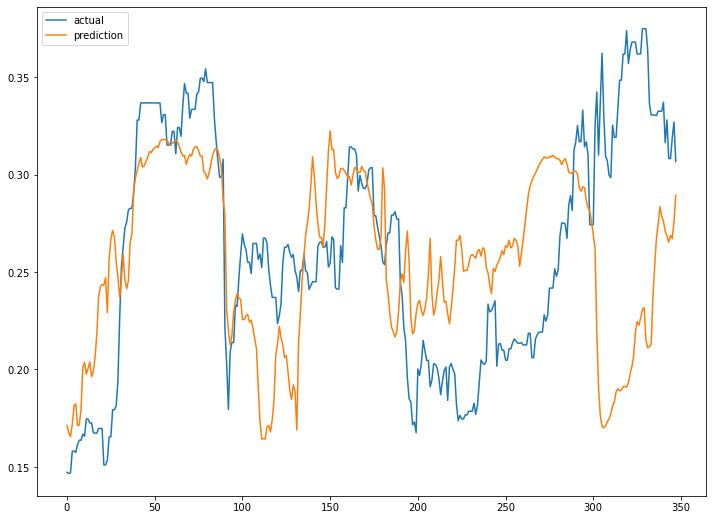

In [16]:
# 예측
pred = model.predict(test_feature)

plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_label, pred)
print(mae)

0.0497277756235976


In [18]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_label, pred)
print(mse)

0.004105205774916956


In [19]:
rmse = np.sqrt(mse)
print(rmse)

0.06407187975170509


In [20]:
predict_score = []
predict_score = pd.DataFrame(predict_score)

In [21]:
predict_score = pd.DataFrame(data=[[mae,mse,rmse]], columns=['MAE','MSE','RMSE'])

In [22]:
predict_score

,MAE,MSE,RMSE
0,0.049728,0.004105,0.064072


#### model.predict 데이터 집합에서 입력된 모델의 출력만 예측합니다. model.predict의 내부 작업은 내부에 사용됩니다. model.evaluate, 그러나 같은 것을 계산하지 않기 때문에 양쪽의 출력은 다르다.

#### model.evaluate 주어진 데이터 집합을 통해 값을 예측하고 모델에 연결된 모든 메트릭을 계산합니다. 손실 및 메트릭이 포함된 목록을 하나의 값으로 반환합니다.